# Model 08

Main idea:
- re-try linear models, this time with feature selection as part of the pipeline, using f-scores

**note**: this notebook requires running `src/features/build_lag52_features.py`

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from os.path import join

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import cross_validate, TimeSeriesSplit

In [6]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150
})
sns.set()

## Reading the data

In [7]:
data_path = '../data/processed'

In [10]:
train_features = pd.read_csv(join(data_path, 'lag52_train_features.csv'))
train_labels = pd.read_csv(join(data_path, 'lag52_train_labels.csv'))
test_features = pd.read_csv(join(data_path, 'lag52_test_features.csv'))

In [12]:
train_features_sj = train_features[train_features['city'] == 'sj'].drop('city', axis = 1)
train_features_iq = train_features[train_features['city'] == 'iq'].drop('city', axis = 1)

train_labels_sj = train_labels[train_labels['city'] == 'sj']['total_cases'].astype('float')
train_labels_iq = train_labels[train_labels['city'] == 'iq']['total_cases'].astype('float')

test_features_sj = test_features[test_features['city'] == 'sj'].drop('city', axis = 1)
test_features_iq = test_features[test_features['city'] == 'iq'].drop('city', axis = 1)

## Models

### San Juan

In [140]:
model_sj = Pipeline([
    ('select', SelectKBest(f_regression, k = 100)),
    ('scale', StandardScaler()),
    ('linear', LinearSVR(kernel = 'rbf', C = 0.1))
])

In [141]:
cv_sj = cross_validate(
    estimator = model_sj,
    scoring = 'neg_mean_absolute_error',
    X = train_features_sj,
    y = train_labels_sj,
    cv = TimeSeriesSplit(10),
    n_jobs = -1
)
print(np.mean(cv_sj['test_score']))
print(np.std(cv_sj['test_score']))

-24.99321039395498
18.2464297979428


#### Visualization

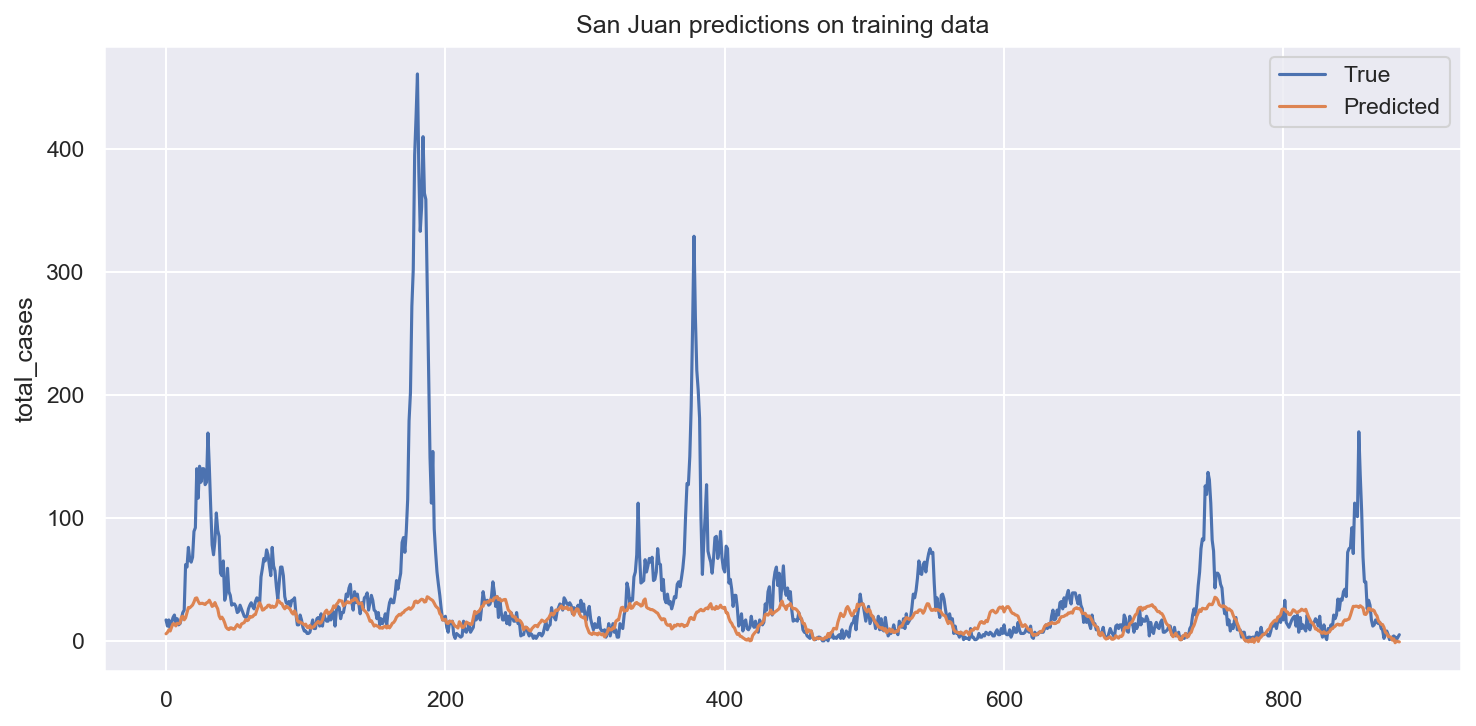

In [83]:
model_sj.fit(train_features_sj, train_labels_sj)
y_val_sj = model_sj.predict(train_features_sj).flatten()

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_sj, x = train_features_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_features_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Iquitos

In [101]:
model_iq = Pipeline([
    ('select', SelectKBest(f_regression, k = 100)),
    ('scale', StandardScaler()),
    ('linear', SVR(C = 0.04))
])

In [102]:
cv_iq = cross_validate(
    estimator = model_iq,
    scoring = 'neg_mean_absolute_error',
    X = train_features_iq,
    y = train_labels_iq,
    cv = TimeSeriesSplit(10),
    n_jobs = -1
)
print(np.mean(cv_iq['test_score']))
print(np.std(cv_iq['test_score']))

-6.65404781023615
3.3190165063694868


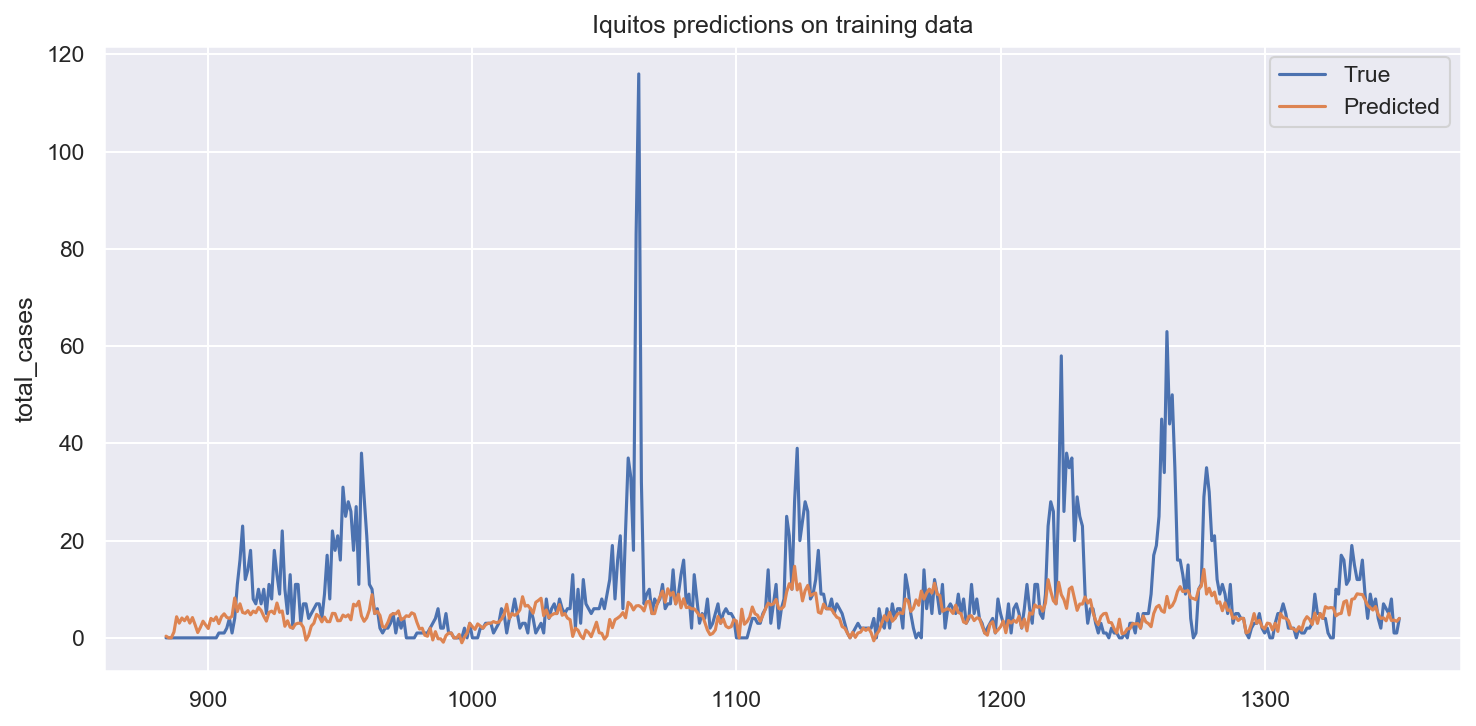

In [103]:
model_iq.fit(train_features_iq, train_labels_iq)
y_val_iq = model_iq.predict(train_features_iq).flatten()

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_iq, x = train_features_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_features_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

## Overall performance

In [105]:
sj_ratio = len(train_features_sj) / len(train_features)
iq_ratio = len(train_features_iq) / len(train_features)

In [107]:
sj_ratio * np.mean(cv_sj['test_score']) + iq_ratio * np.mean(cv_sj['test_score'])

-22.760669363462185

Not as good as previous cv scores (eg. ProgressiveRegression submission) but it's possible 
that the result will nonetheless be good (SVMs are more robust and CV score has not always been 
a good indicator)

## Prediction

In [111]:
submission = pd.read_csv(join('../data/raw', 'submission_format.csv'))

y_pred_sj = model_sj.predict(test_features_sj)
y_pred_iq = model_iq.predict(test_features_iq)
y_pred = np.concatenate((y_pred_sj, y_pred_iq))

submission['total_cases'] = np.round(y_pred).astype(int)
submission.to_csv(
    join('../models', 'lag52_svm.csv'),
    index = None
)

### Visualization

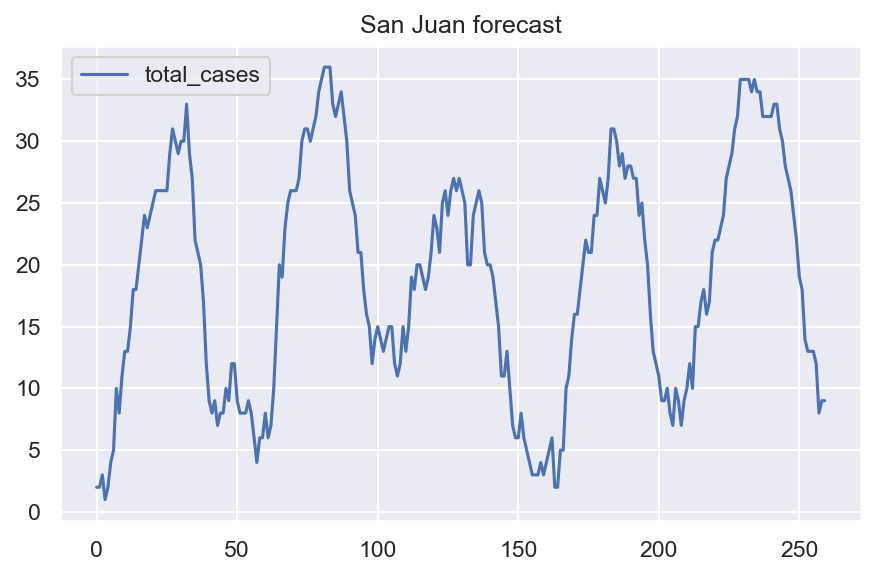

In [113]:
submission[submission['city'] == 'sj'].plot(
    y = 'total_cases',
    title = 'San Juan forecast'
)

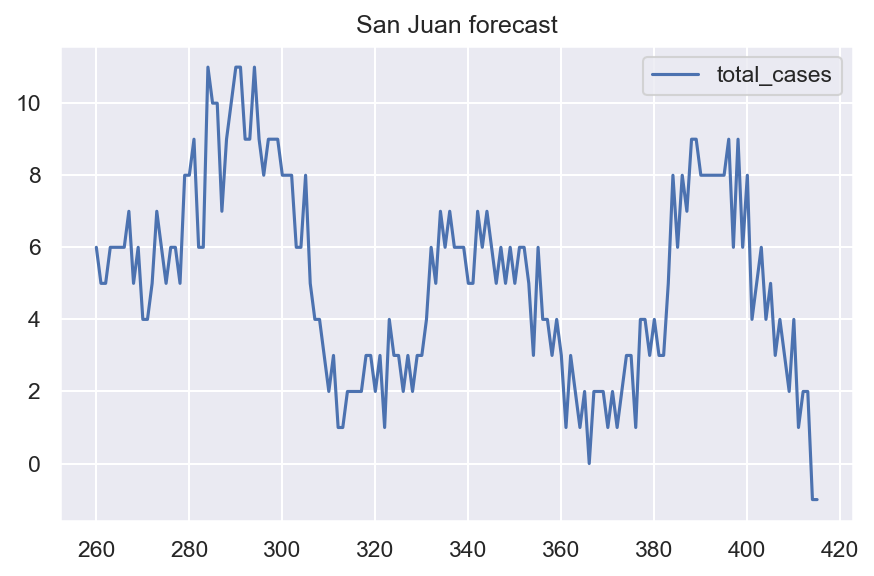

In [114]:
submission[submission['city'] == 'iq'].plot(
    y = 'total_cases',
    title = 'San Juan forecast'
)

### Results